In [2]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../../figures/')

In [22]:
files = list(Path(f'../snakemake/tables/').glob('effect_of_multi_vs_single_PCA_*.csv'))
# exclude files with few total perturbations or no significant ones to lose to begin with
selected_files = []
for file in files:
    sdf = pd.read_csv(file, index_col=0)
    if len(sdf.index.unique())<30 or (True not in sdf.significant_adj.value_counts().index) or (sdf.multiPCA.sum()==0):
        continue
    else:
        selected_files.append(file)

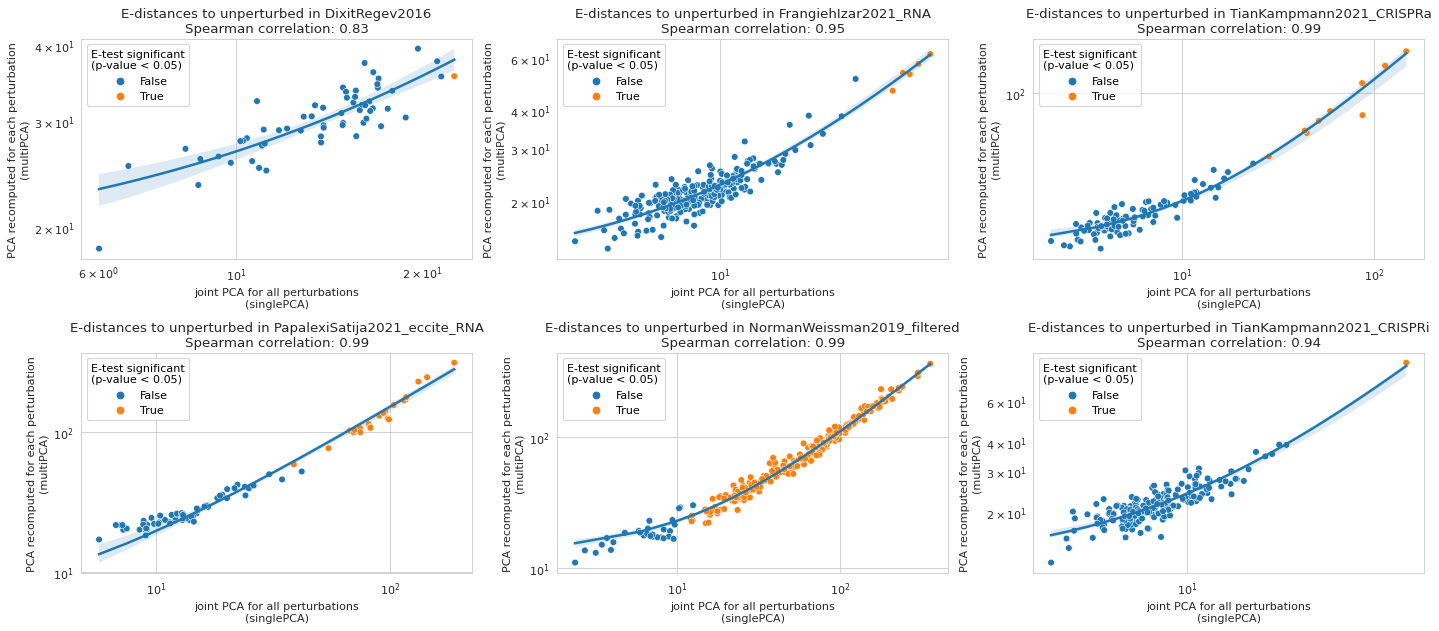

In [31]:
N=len(selected_files)
rows = 2
with sns.axes_style('whitegrid'):
    axs = np.ravel(pl.subplots(rows, int(N/rows), figsize=(6*N/rows, 4*rows), dpi=80)[-1])

for ax, file in zip(axs, selected_files):
    sdf = pd.read_csv(file, index_col=0)
    dataset = file.name.replace('effect_of_multi_vs_single_PCA_', '').replace('_tables.csv', '')
    sdf = sdf.drop('control')
    
    sns.regplot(data=sdf, x='singlePCA', y='multiPCA', ax=ax, scatter_kws={'s': 0})
    sns.scatterplot(data=sdf, x='singlePCA', y='multiPCA', hue='significant_adj', ax=ax)
    if 'sciplex' in dataset:
        break
    from scipy.stats import pearsonr
    r = pearsonr(sdf.singlePCA, sdf.multiPCA)[0]
    ax.set_title(f'E-distances to unperturbed in {dataset}\nSpearman correlation: {np.round(r,2)}')
    ax.set_xlabel('joint PCA for all perturbations\n(singlePCA)')
    ax.set_ylabel('PCA recomputed for each perturbation\n(multiPCA)')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend(title='E-test significant\n(p-value < 0.05)')
pl.tight_layout()
pl.savefig(figure_path / 'SuppFig5_singlevsmultiPCA.pdf')
pl.show()